In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms, models
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import pickle
import torch.nn as nn
import time

## Loading Data

In [2]:
with open("test_image.pkl", "rb") as f:
    testImages = pickle.load(f)
with open("train_image.pkl", "rb") as f:
    trainImages = pickle.load(f)
with open("train_label.pkl", "rb") as f:
    trainLabels = pickle.load(f)

In [3]:
# Replacing class label 6 with 1
for i in range(8000):
    if(trainLabels[i]==6): 
        trainLabels[i] = 1

In [4]:
trainImages = (np.asarray(trainImages)).reshape(-1,1,28,28)
testImages = (np.asarray(testImages)).reshape(-1,1,28,28)

trainImages = (torch.from_numpy(trainImages)).float()
trainLabels = torch.from_numpy(np.asarray(trainLabels))
testImages = (torch.from_numpy(np.asarray(testImages))).float()

In [5]:
BatchSize = 64

trainset = torch.utils.data.TensorDataset(trainImages, trainLabels)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize, shuffle=True, num_workers=4)

## Defining Model

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(6400,512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x)


In [12]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)


In [13]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available !')   
    net = net.cuda()
else:
    print('GPU unavailable !')

GPU unavailable !


In [14]:
criterion = nn.NLLLoss() # Negative Log-likelihood
optimizer = optim.Adam(net.parameters(), lr=1e-5) # Adam

## training model

/home/harshit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 /5  ;  Training Loss: 0.009089 ; Time consumed: 0m 8s 
Epoch: 2 /5  ;  Training Loss: 0.008047 ; Time consumed: 0m 7s 
Epoch: 3 /5  ;  Training Loss: 0.007541 ; Time consumed: 0m 6s 
Epoch: 4 /5  ;  Training Loss: 0.007030 ; Time consumed: 0m 7s 
Epoch: 5 /5  ;  Training Loss: 0.006544 ; Time consumed: 0m 8s 


NameError: name 'start' is not defined

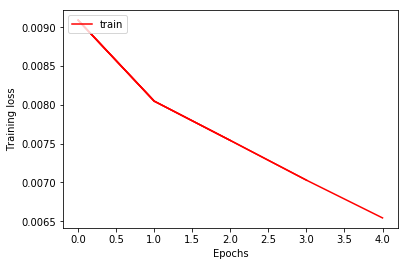

In [16]:
totalEpochs = 5
trainLossList = []
startTime = time.time()
for epoch in range(totalEpochs):
    epochStart = time.time()
    runningLoss = 0    
    net.train(True) # For training
    for data in trainLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)  
       
        # Initialize gradients to zero
        optimizer.zero_grad()
        # Feed-forward input data through the network        
        outputs = net(inputs)        
        # Compute loss/error
        loss = criterion(outputs, labels)
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.data 
    avgTrainLoss = runningLoss/8000.0
    trainLossList.append(avgTrainLoss)
        
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLossList,'r-',label='train')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Training loss')       
    epochEnd = time.time()-epochStart
    print('Epoch: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,totalEpochs,avgTrainLoss,epochEnd//60,epochEnd%60))
end = time.time()-startTime
print('Training finished in {:.0f}m {:.0f}s'.format(end//60,end%60))

## Predicting test labels and saving into file

In [17]:
if use_gpu:
    inputs = Variable(testImages.cuda())  
else:
    inputs = Variable(testImages)

outputs = net(inputs)
_, predicted = torch.max(outputs.data, 1)
finalPred = predicted.cpu().numpy()

# Replacing class label 1 with 6
for i in range(2000):
    if finalPred[i] == 1:
        finalPred[i] = 6

/home/harshit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [18]:
# Saving predictions into a file
x = np.arange(0, 2000, 1)
x.astype(int)
final = np.asarray((x,finalPred),dtype = int)
np.savetxt("Testlabel.csv",final.T,fmt='%d' ,delimiter=',', header='image,pred',comments='')